In [51]:
import pandas as pd
import numpy as np
import os

df1 = pd.read_csv('MLP_embed-86.csv')
df1 = pd.read_csv('catboost_submission.csv')
df2 = pd.read_csv('catboost_submission2.csv')
df1 = df1.sort_values(by=['ID'], ignore_index=True)
df2 = df2.sort_values(by=['ID'], ignore_index=True)
(df1['Target'] == df2['Target']).mean()

0.9301634472511144

In [ ]:
import pandas as pd
import numpy as np

data2 = pd.read_csv(r'appian-x-iit-madras-hackathon-april-2025\train.csv')
test2 = pd.read_csv(r'appian-x-iit-madras-hackathon-april-2025\test.csv')

data2.replace('Alone', 'Single', inplace=True)
test2.replace('Absurd', 'Single', inplace=True)
data2.replace('YOLO', 'Single', inplace=True)
test2.replace('YOLO', 'Single', inplace=True)
# test.replace('Alone', 'Single', inplace=True)
# data.replace('Together', 'Married', inplace=True)
# test.replace('Together', 'Married', inplace=True)

# test.replace('Basic', '2n Cycle', inplace=True)
# data.replace('Basic', '2n Cycle', inplace=True)
# test.replace('Widow', 'Divorced', inplace=True)
# data.replace('Widow', 'Divorced', inplace=True)

data2['Dt_Customer_1'] = pd.to_datetime(data2['Dt_Customer'],format='mixed')
data2['Dt_Customer_1'] = data2['Dt_Customer_1']-min(data2['Dt_Customer_1'])
data2['Dates']=data2['Dt_Customer_1'].dt.days

test2['Dt_Customer_1'] = pd.to_datetime(test2['Dt_Customer'],format='mixed')
test2['Dt_Customer_1'] = test2['Dt_Customer_1']-min(test2['Dt_Customer_1'])
test2['Dates']=test2['Dt_Customer_1'].dt.days
Education = {}
Marital_status = {}
A = data2['Education'].unique()
B = data2['Marital_Status'].unique()

spend_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
data2['TotalSpend']       = data2[spend_cols].sum(axis=1)
for col in spend_cols:
    data2[col + '_Pct']   = data2[col] / (data2['TotalSpend'] + 1e-6)

data2['TotalAccepted']    = data2[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']].sum(axis=1)
data2['DealAcceptanceRate']= data2['NumDealsPurchases'] / (data2['NumStorePurchases'] + data2['NumWebPurchases'] + data2['NumCatalogPurchases'] + 1e-6)

In [ ]:
from re import X
from catboost import train


# lists = [
#     'Year_Birth',
#     'Income',
#     'Kidhome',
#     'Teenhome',
#     'Dates',
#     'Recency',
#     'MntWines',
#     'MntFruits',
#     'MntMeatProducts',
#     'MntFishProducts',
#     'MntSweetProducts',
#     'MntGoldProds',
#     'NumWebPurchases',
#     'NumCatalogPurchases',
#     'NumStorePurchases',
#     'NumDealsPurchases',
#     'NumWebVisitsMonth',
#     'AcceptedCmp1',
#     'AcceptedCmp2',
#     'AcceptedCmp3',
#     'AcceptedCmp4',
#     'AcceptedCmp5',
#     'Complain',
#     # 'Marital_Status_Married',
#     # 'Marital_Status_Single',
#     # 'Education_Graduation',
#     # 'Education_Master',
#     # 'Education_PhD',
#     'Marital_Status',
#     'Education'
#     # 'Target'
# ]
import pandas as pd

# 1) Create the new features on your DataFrame (here called `data2`):
data2 = data2.copy()
data2['Age'] = 2025 - data2['Year_Birth']
q1,q99 = data2['Age'].quantile([0.01, 0.99])
data2['Age'] = data2['Age'].clip(q1, q99)

q1, q99 = data2['Income'].quantile([0.01, 0.99])
data2['Income_clipped'] = data2['Income'].clip(q1, q99)
data2['Income_log'] = np.log1p(data2['Income_clipped'])

# If your “Dates” column is already a numeric “days since enrollment” use it directly;
# otherwise convert a datetime:
# data2['Dates'] = (pd.to_datetime('2025-04-18') - pd.to_datetime(data2['Dt_Customer'])).dt.days
data2['Tenure'] = data2['Dates']  # assuming 'Dates' already gives days since enrollment

# Total spend and spend percentages
spend_cols = [
    'MntWines','MntFruits','MntMeatProducts',
    'MntFishProducts','MntSweetProducts','MntGoldProds'
]
data2['TotalSpend'] = data2[spend_cols].sum(axis=1)
for c in spend_cols:
    data2[c + '_Pct'] = data2[c] / (data2['TotalSpend'] + 1e-6)

# Campaign response rates
cmp_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
data2['TotalAccepted']     = data2[cmp_cols].sum(axis=1)
data2['DealAcceptanceRate']= data2['NumDealsPurchases'] / (
    data2[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1) + 1e-6
)

# 2) Now define your new feature list (in the exact order you want):
lists = [
    # Demographics & tenure
    'Age',
    'Income_log',
    'Kidhome',
    'Teenhome',
    'Tenure',
    'Recency',
    'Complain',

    # Raw spends
    *spend_cols,           # expands to the six spend columns
    'TotalSpend',
    *[c + '_Pct' for c in spend_cols],

    # Web/store/catalog activity
    'NumWebVisitsMonth',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',

    # Deal/campaign history
    'NumDealsPurchases',
    'DealAcceptanceRate',
    *cmp_cols,             # the five AcceptedCmp# columns
    'TotalAccepted',

    # Categorical
    'Marital_Status',
    'Education'
]

cat_features = ['Education','Marital_Status']
x = data2[lists].copy()
y = data2['Target'].copy()


In [20]:
data2['Recency'].max()

99

In [39]:
import pandas as pd
import numpy as np

def preprocess_appian(df, reference_date="2025-04-18"):
    df = df.copy()
    
    # 1) Parse enrollment date into components
    df['Dt_Customer']      = pd.to_datetime(df['Dt_Customer'], dayfirst=True, errors='coerce')
    df['Enroll_Year']      = df['Dt_Customer'].dt.year
    df['Enroll_Month']     = df['Dt_Customer'].dt.month
    df['Enroll_DayOfWeek'] = df['Dt_Customer'].dt.dayofweek
    df['Enroll_Day']       = df['Dt_Customer'].dt.day
    
    # 2) Age at reference date
    ref = pd.to_datetime(reference_date)
    df['Age'] = ref.year - df['Year_Birth']
    q1, q99 = df['Age'].quantile([0.01, 0.99])
    df['Age'] = df['Age'].clip(q1, q99)
    
    # 3) Income preprocessing
    q1, q99 = df['Income'].quantile([0.01, 0.99])
    df['Income_clipped'] = df['Income'].clip(q1, q99)
    df['Income_log']     = np.log1p(df['Income_clipped'])
    df['Income_missing'] = df['Income'].isna().astype(int)
    
    # 4) Household composition
    df['Kids_total']   = df['Kidhome'] + df['Teenhome']
    df['Kid_ratio']    = df['Kidhome']  / (df['Kids_total'] + 1e-6)
    df['Teen_ratio']   = df['Teenhome'] / (df['Kids_total'] + 1e-6)
    
    # 5) Recency buckets
    df['Recency_bucket'] = pd.cut(
        df['Recency'],
        bins=[-1,7,30,60,df['Recency'].max()],
        labels=False
    )
    
    # 6) Spending features & percentages
    spend_cols = [
        'MntWines','MntFruits','MntMeatProducts',
        'MntFishProducts','MntSweetProducts','MntGoldProds'
    ]
    df['TotalSpend'] = df[spend_cols].sum(axis=1)
    for c in spend_cols:
        df[c + '_Pct'] = df[c] / (df['TotalSpend'] + 1e-6)
    
    # 7) Purchase behavior
    df['TotalPurchases'] = (
        df['NumWebPurchases'] +
        df['NumCatalogPurchases'] +
        df['NumStorePurchases']
    )
    # Safely compute per‑purchase ratios
    df['AvgSpend_per_Purchase'] = np.where(
        df['TotalPurchases'] > 0,
        df['TotalSpend'] / df['TotalPurchases'],
        0.0
    )
    df['Visits_per_Purchase'] = np.where(
        df['TotalPurchases'] > 0,
        df['NumWebVisitsMonth'] / df['TotalPurchases'],
        0.0
    )
    
    # 8) Campaign responsiveness
    cmp_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
    df['TotalAccepted'] = df[cmp_cols].sum(axis=1)
    df['DealAcceptanceRate'] = np.where(
        df['TotalPurchases'] > 0,
        df['NumDealsPurchases'] / df['TotalPurchases'],
        0.0
    )
    
    # 9) Final feature & cat lists
    feature_cols = [
        'Enroll_Year','Enroll_Month','Enroll_DayOfWeek','Enroll_Day',
        'Age','Income_log','Income_missing','Recency','Recency_bucket','Complain',
        'Kids_total','Kid_ratio','Teen_ratio',
        *spend_cols,'TotalSpend', *[c+'_Pct' for c in spend_cols],
        'TotalPurchases','AvgSpend_per_Purchase','Visits_per_Purchase',
        'NumDealsPurchases','DealAcceptanceRate','TotalAccepted',
        'NumWebVisitsMonth','NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
        'Marital_Status','Education'
    ]
    cat_features = ['Marital_Status','Education']
    
    return df, feature_cols, cat_features
train_proc, feature_cols, cat_features = preprocess_appian(data2)


In [43]:
train_proc['Visits_per_Purchase'].argmax()

9

In [46]:
train_proc['TotalSpend']

0       1617.0
1         27.0
2        776.0
3         53.0
4        422.0
         ...  
1562      17.0
1563     792.0
1564      92.0
1565     407.0
1566    1269.0
Name: TotalSpend, Length: 1567, dtype: float64

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution_by_target(df, column, target_column):
    """
    Plots a histogram and KDE of a numeric column grouped by a binary target.

    Args:
    - df: pandas DataFrame
    - column: str, column name of numeric feature to plot
    - target_column: str, name of binary target column (0/1)
    """
    plt.figure(figsize=(10, 6))

    for target_val, color, label in zip([0, 1], ['red', 'blue'], ['Target = 0', 'Target = 1']):
        subset = df[df[target_column] == target_val]
        sns.histplot(subset[column], kde=True, color=color, label=label, stat='frequency', bins=30, alpha=0.5)

    plt.title(f'{column} Distribution by {target_column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
plot_distribution_by_target(data2, column='Income', target_column='Target')


In [ ]:
plot_distribution_by_target(data2, column='Income_log', target_column='Target')

In [ ]:
plot_distribution_by_target(data2, column='Income_log', target_column='Target')

In [ ]:
for i in lists:
    plot_distribution_by_target(data2, column=i, target_column='Target')

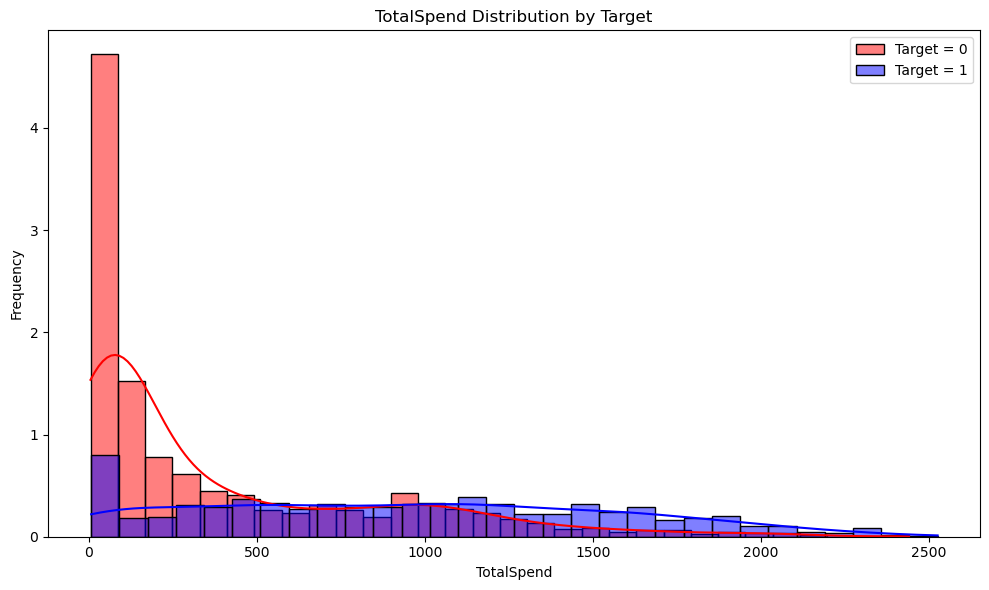

In [47]:
plot_distribution_by_target(train_proc, column='TotalSpend', target_column='Target')

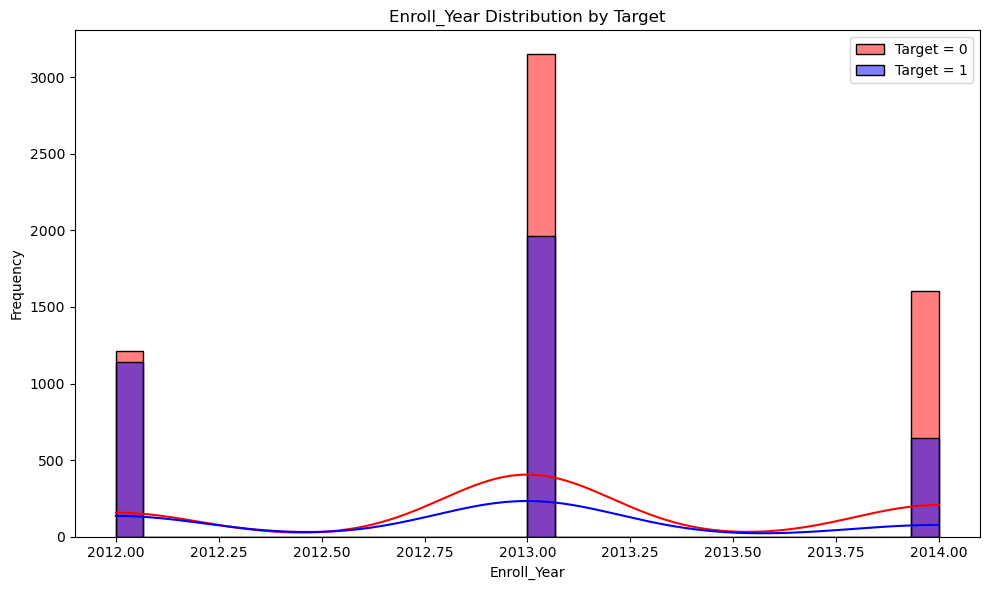

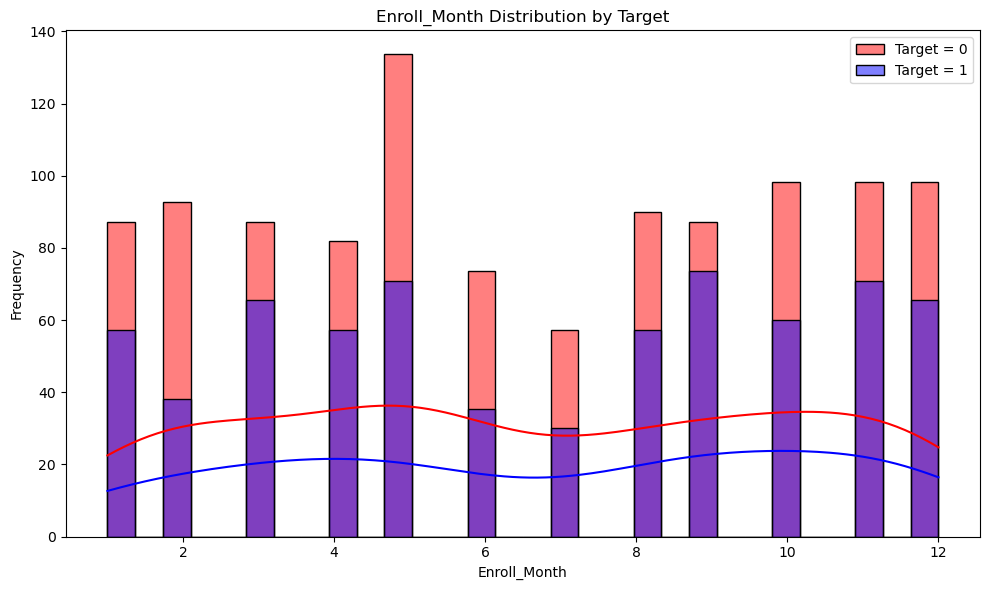

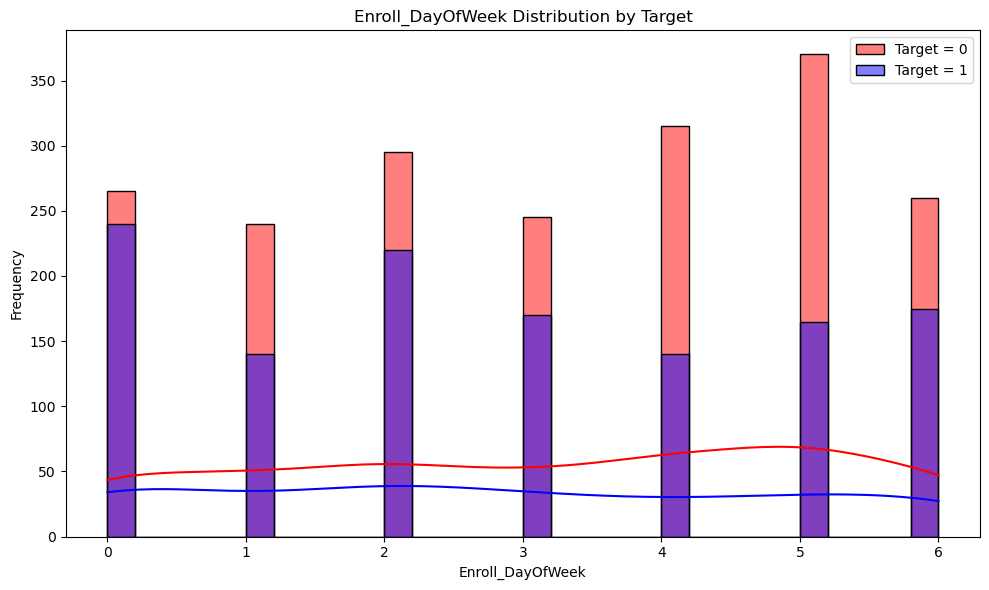

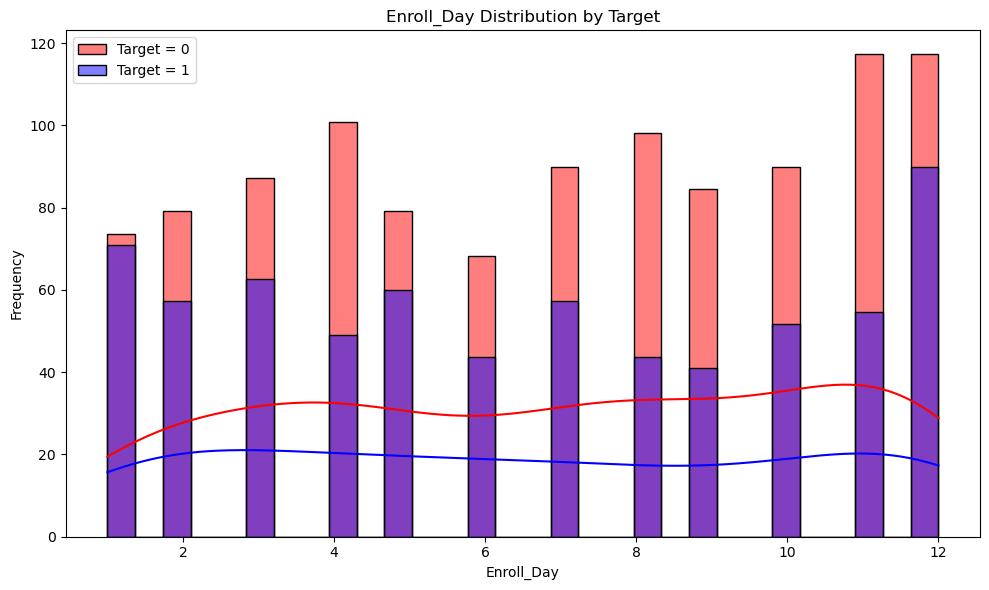

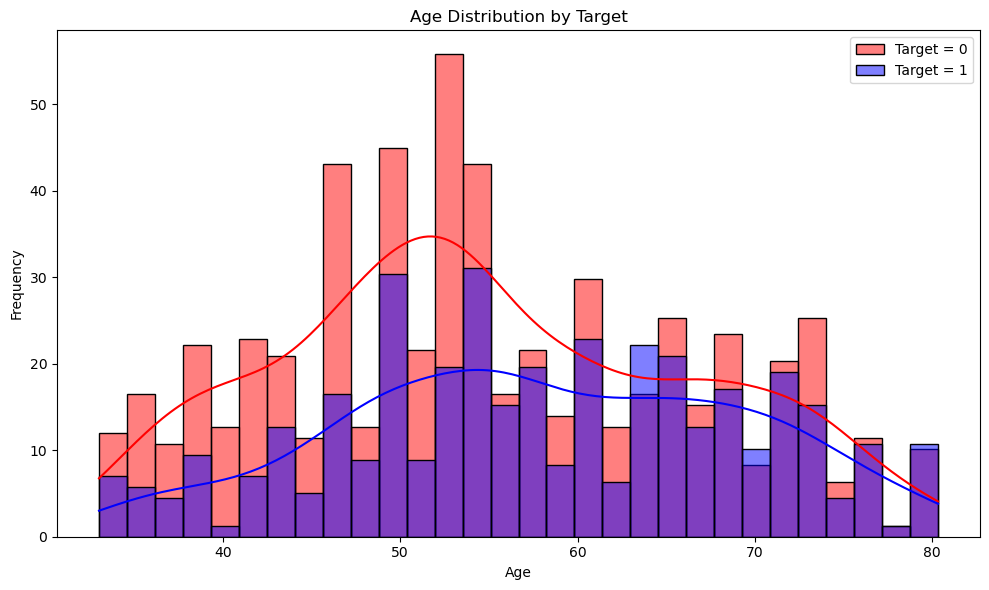

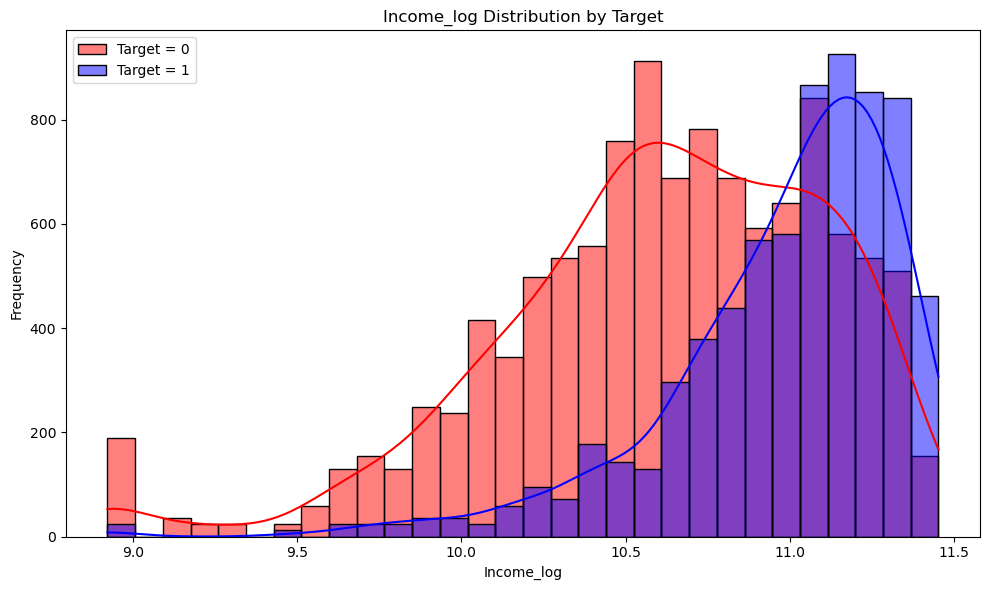

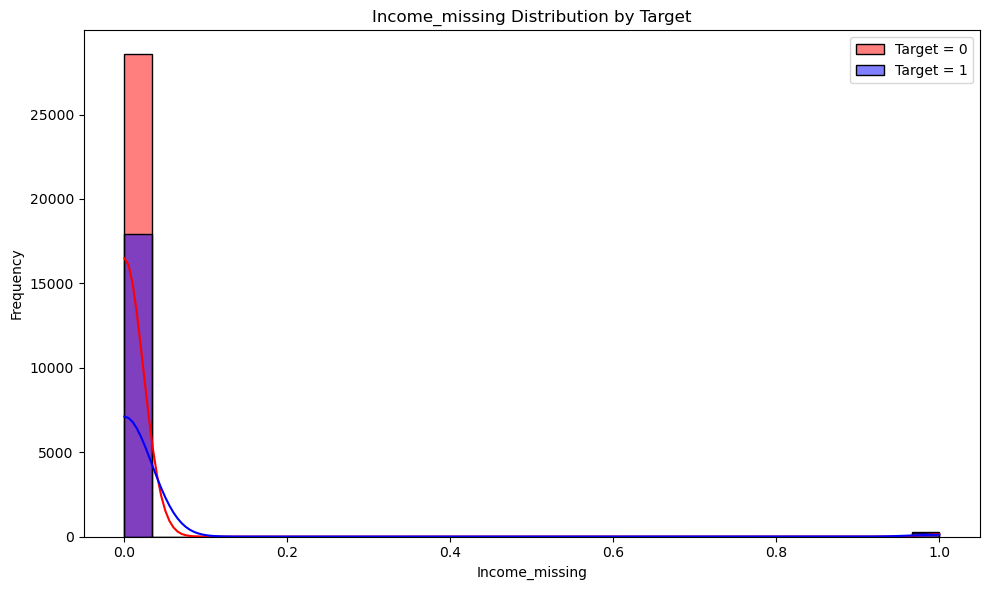

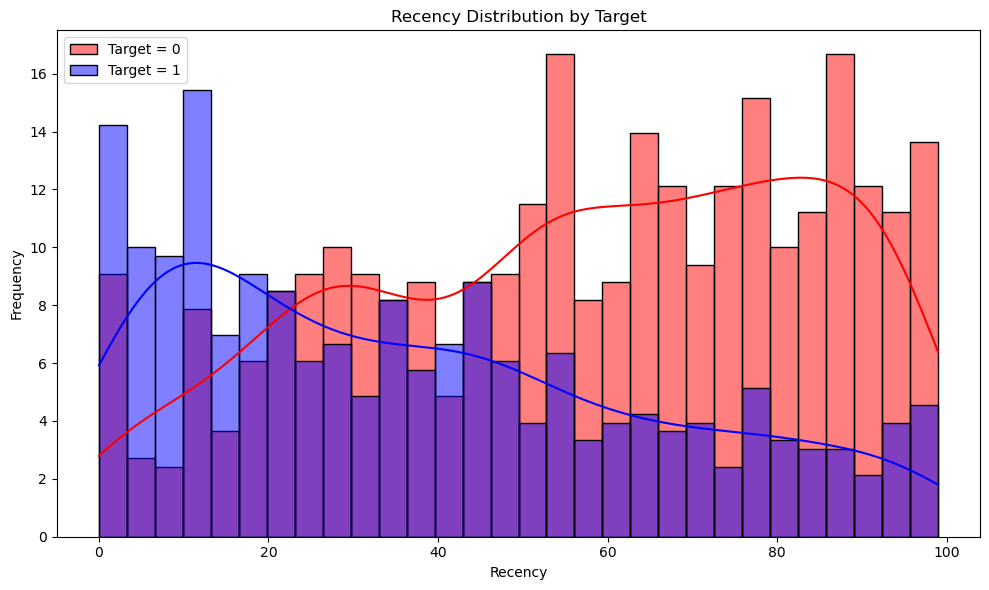

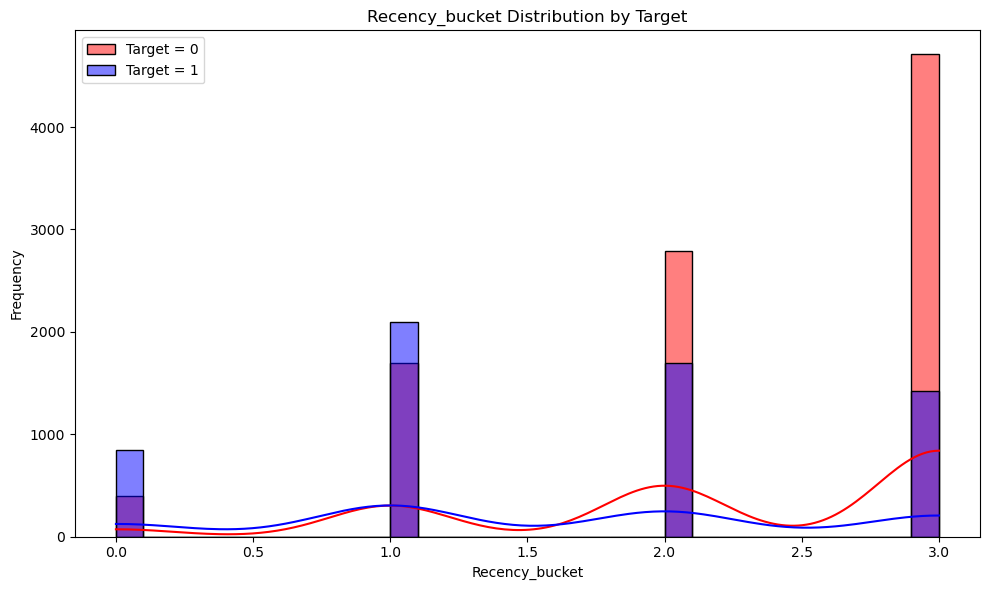

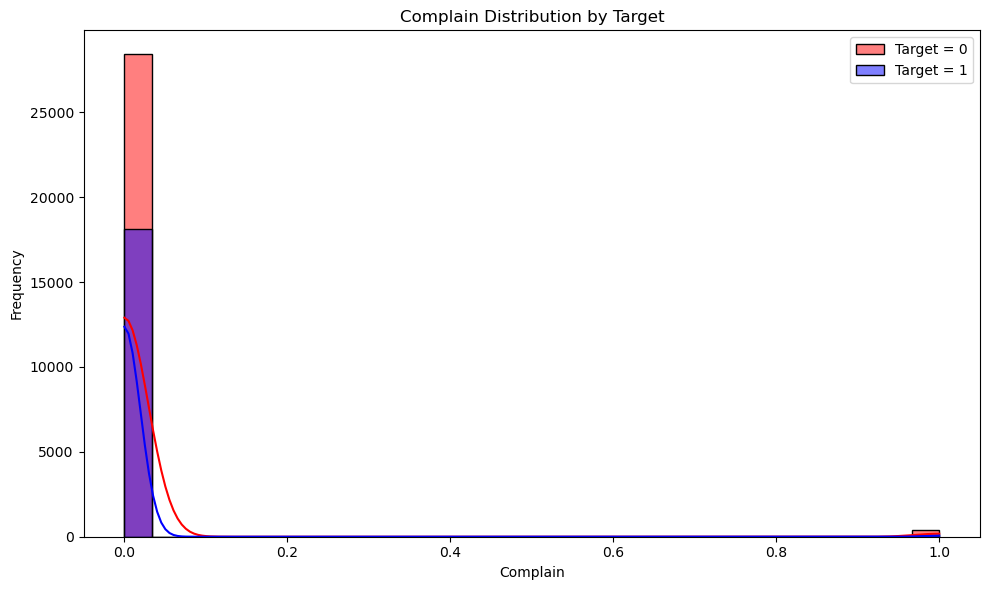

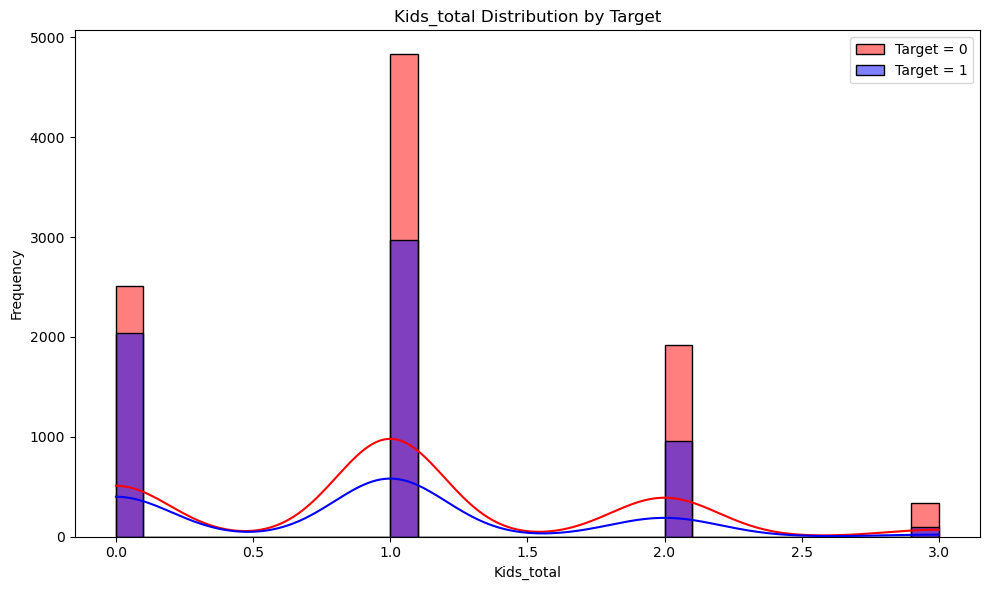

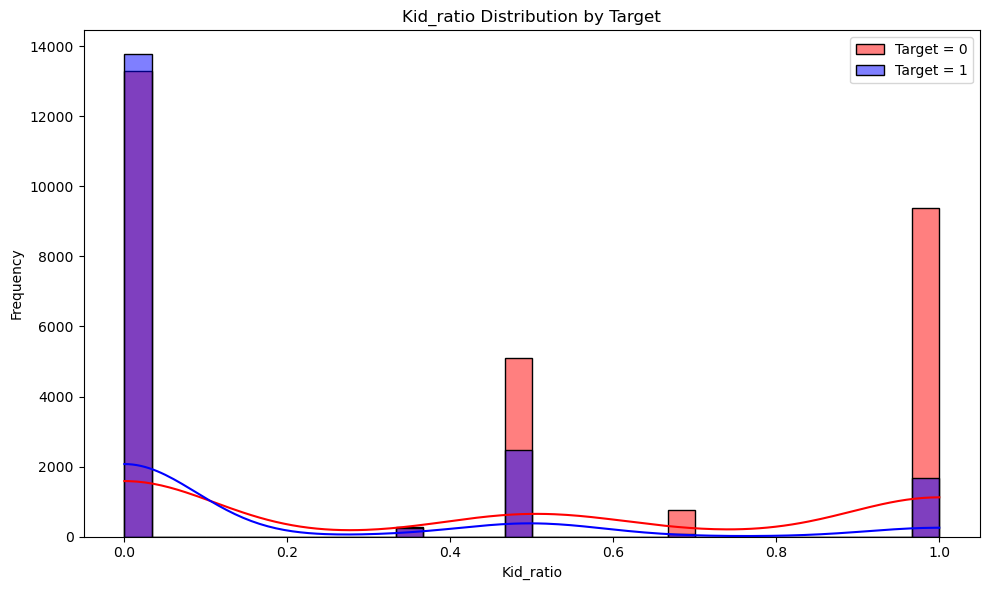

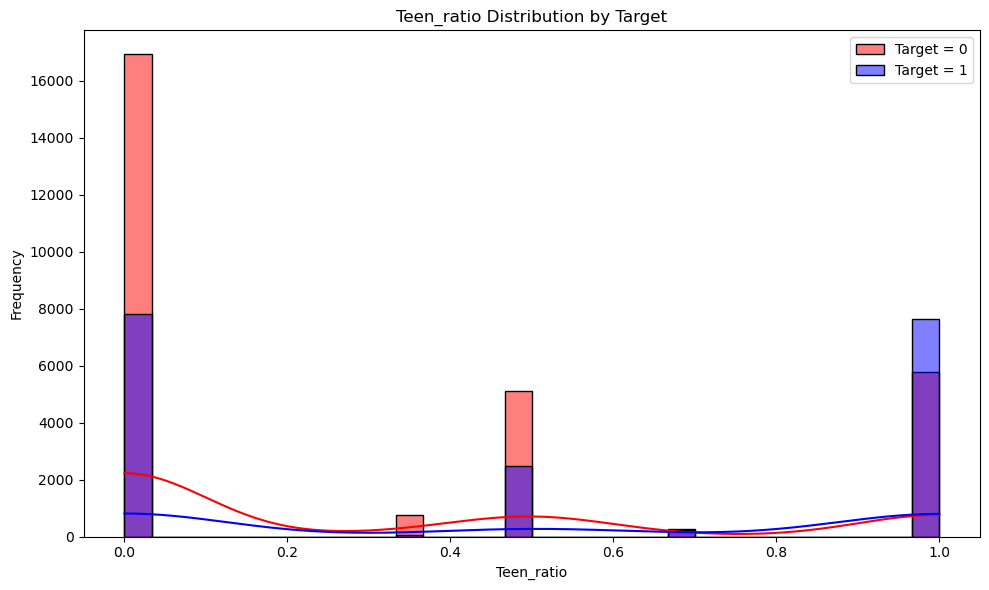

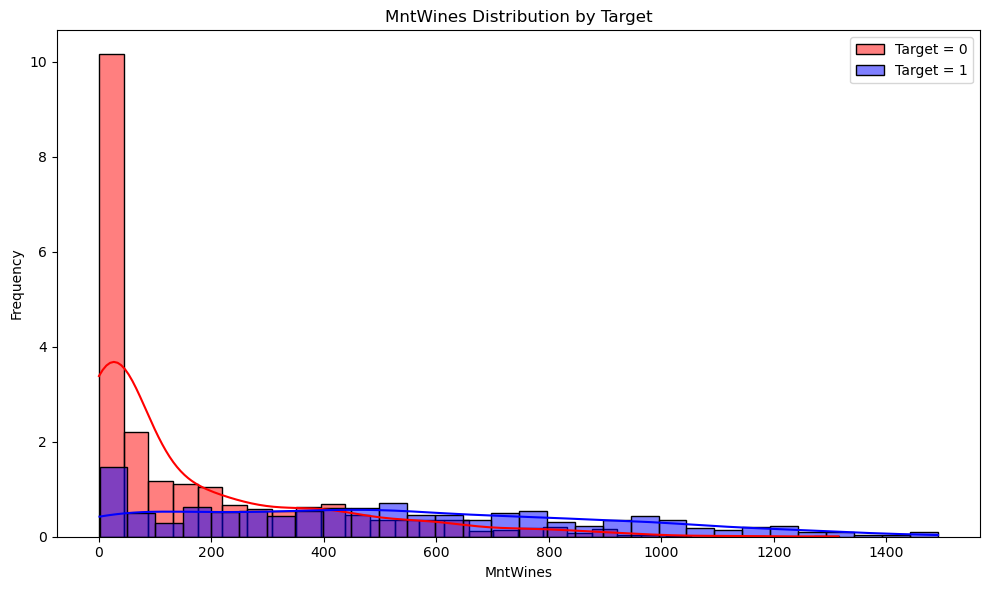

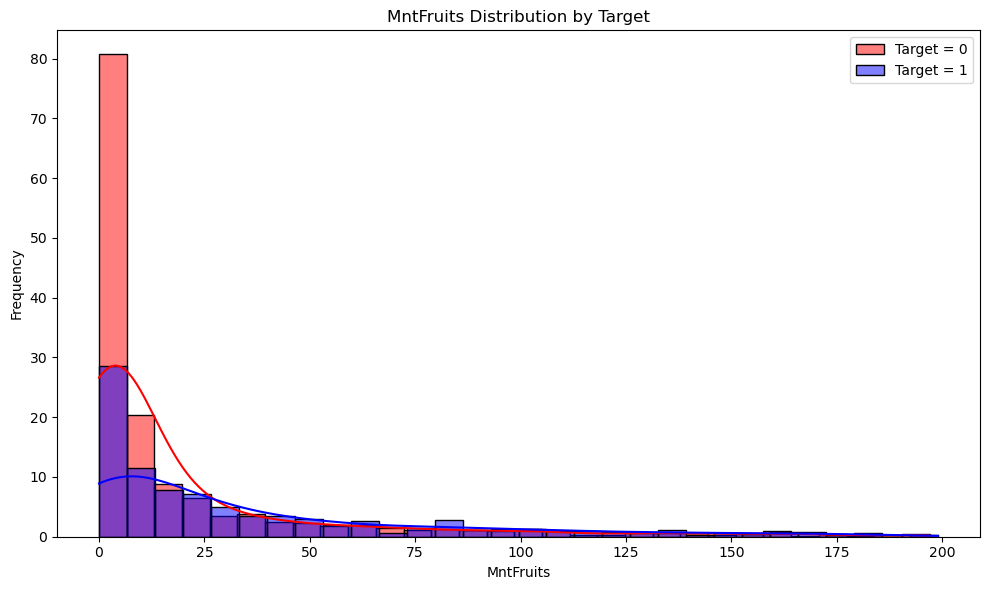

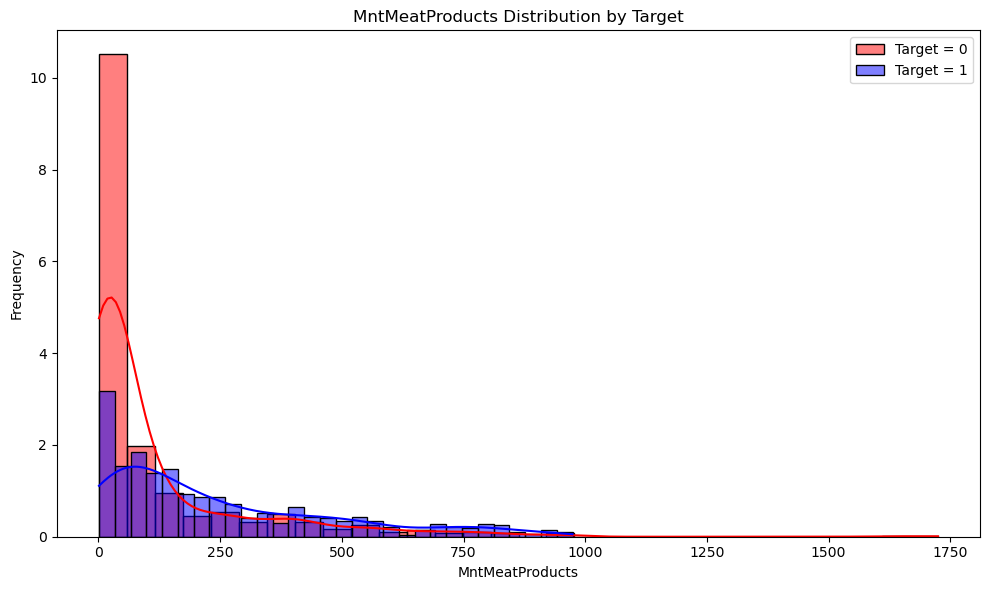

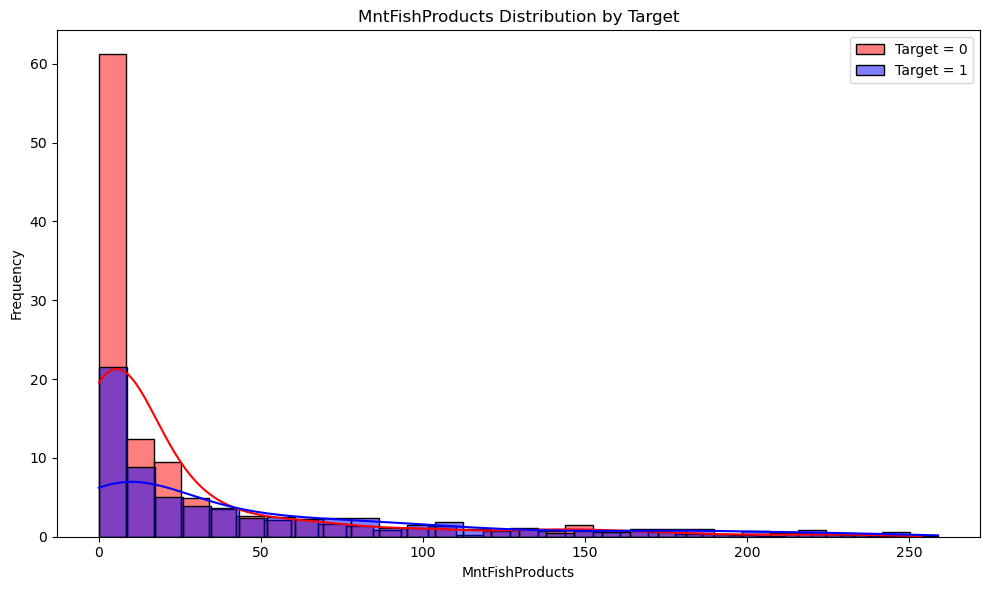

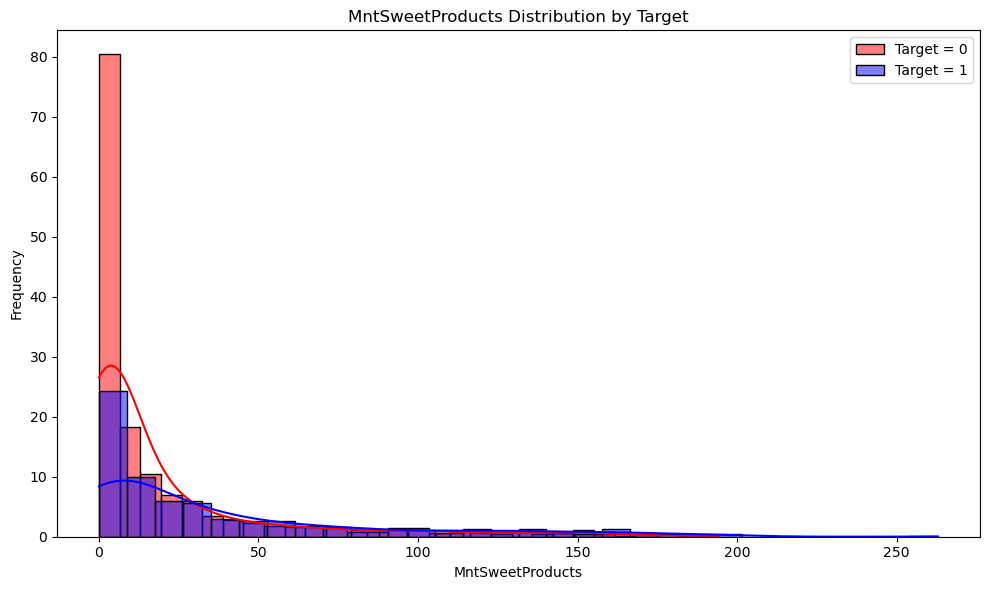

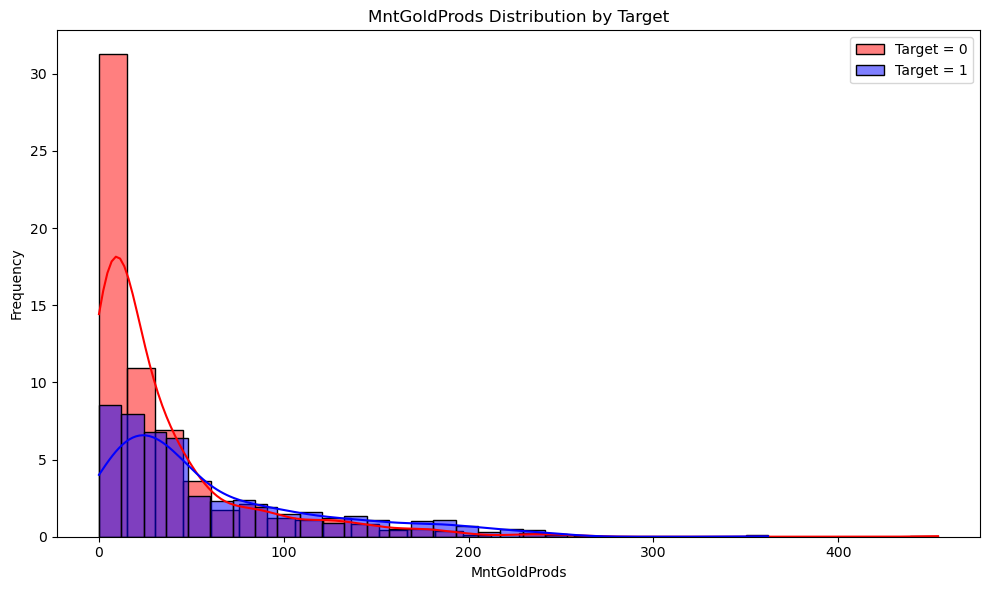

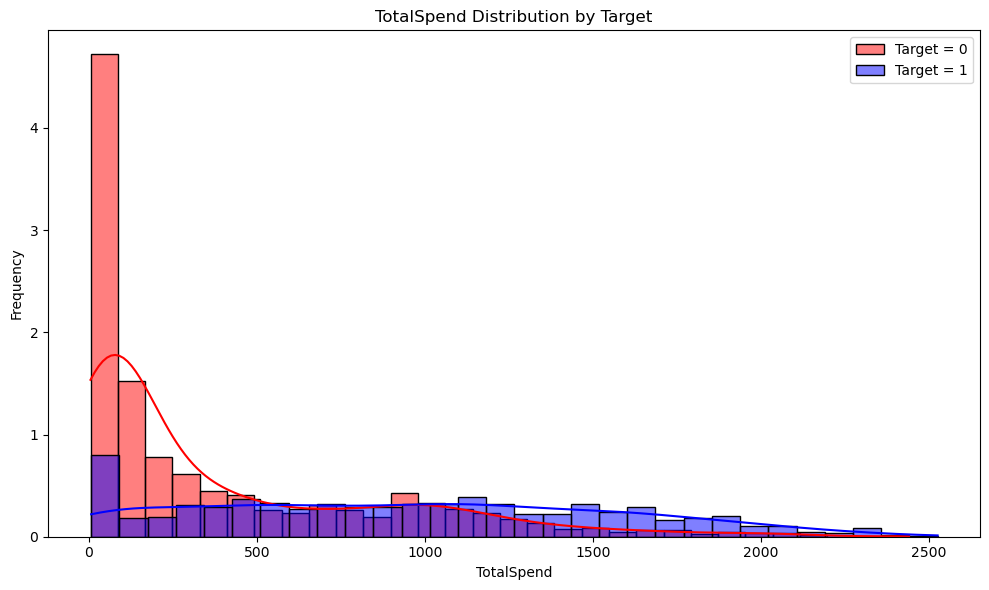

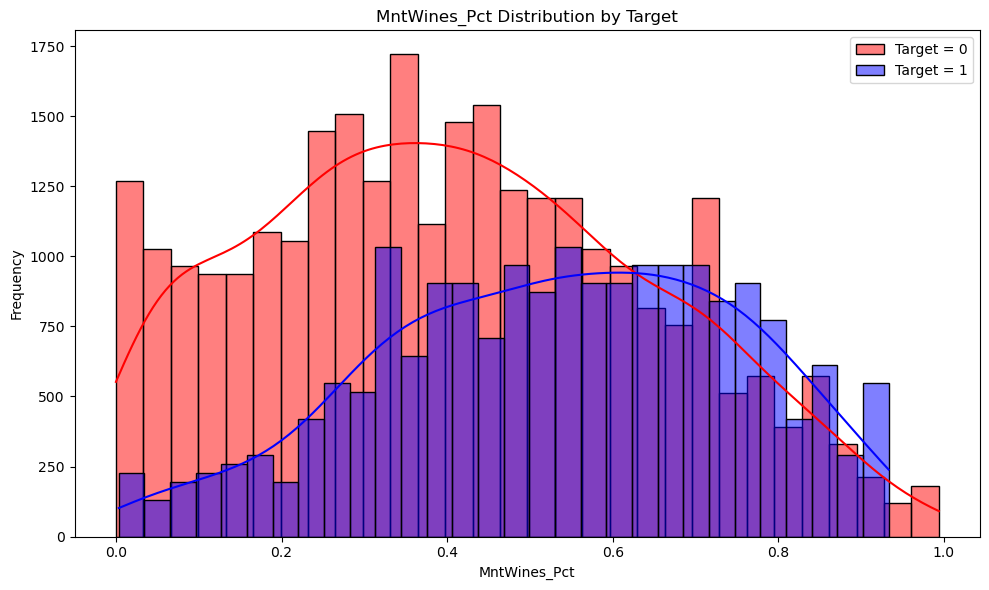

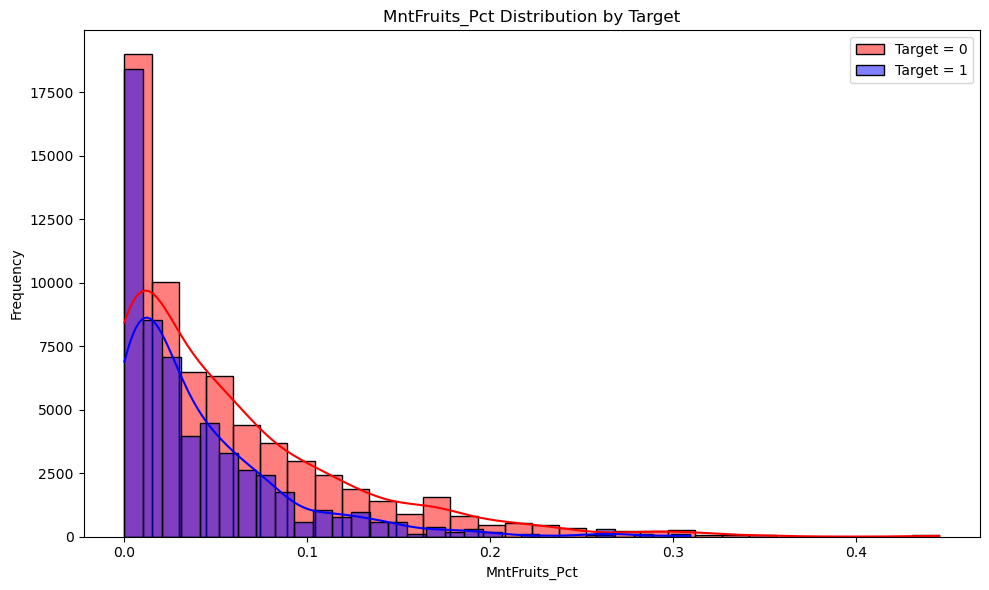

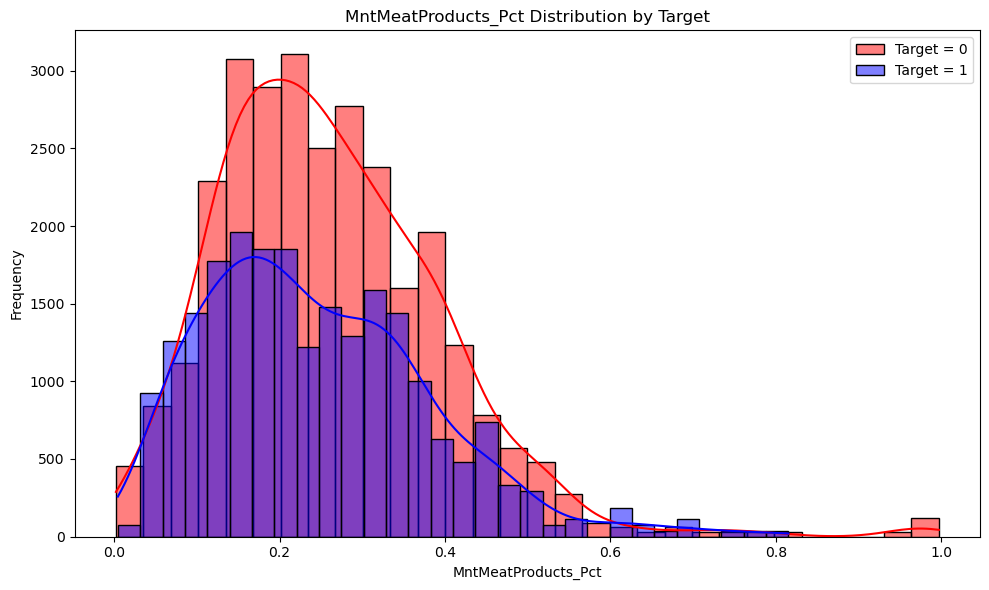

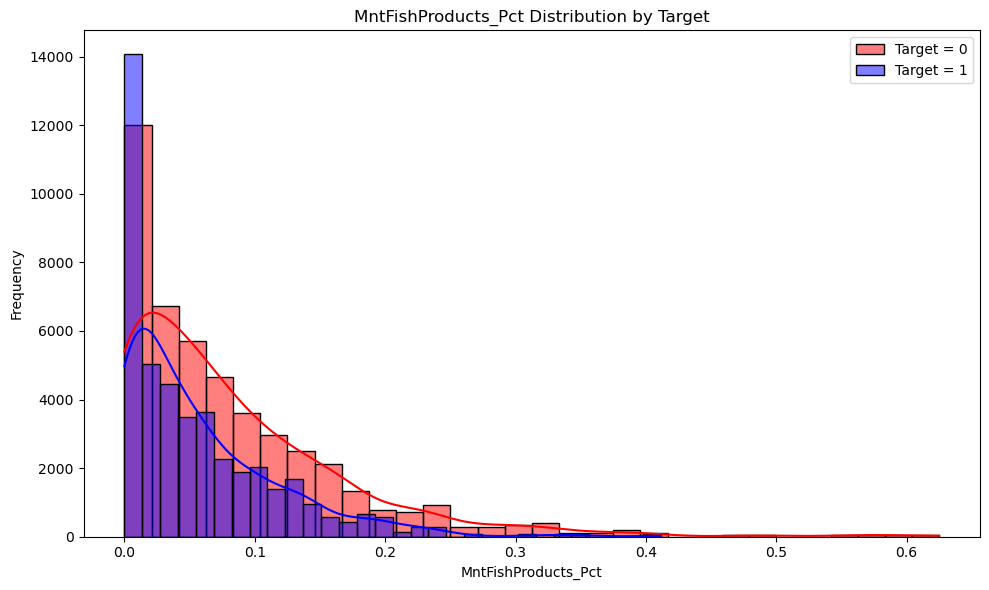

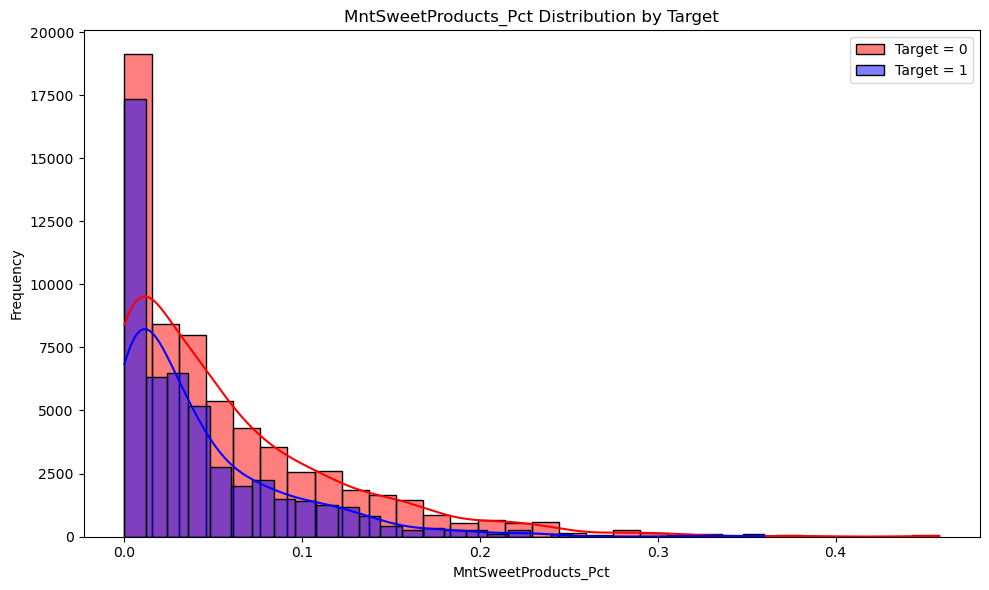

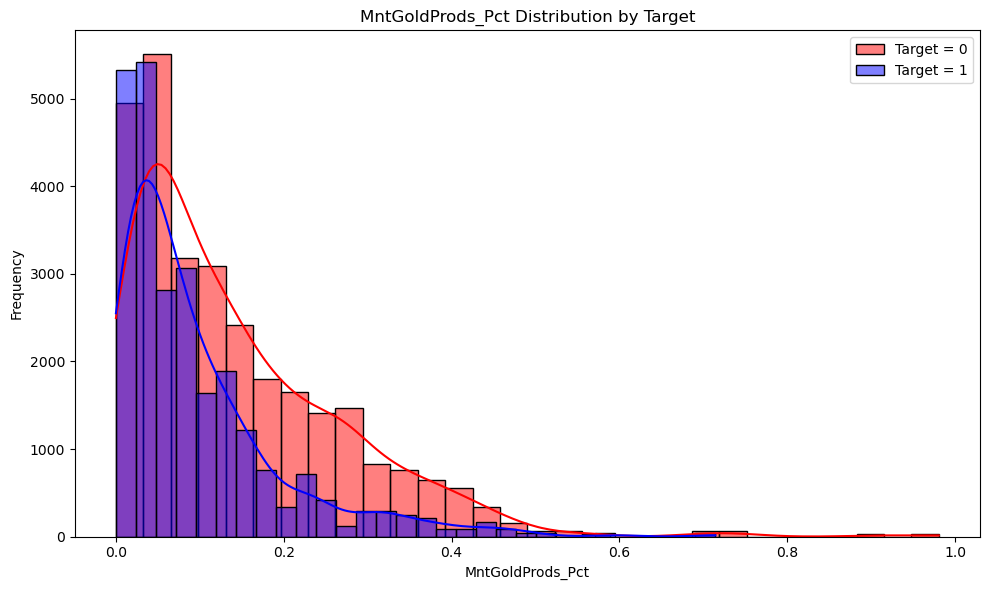

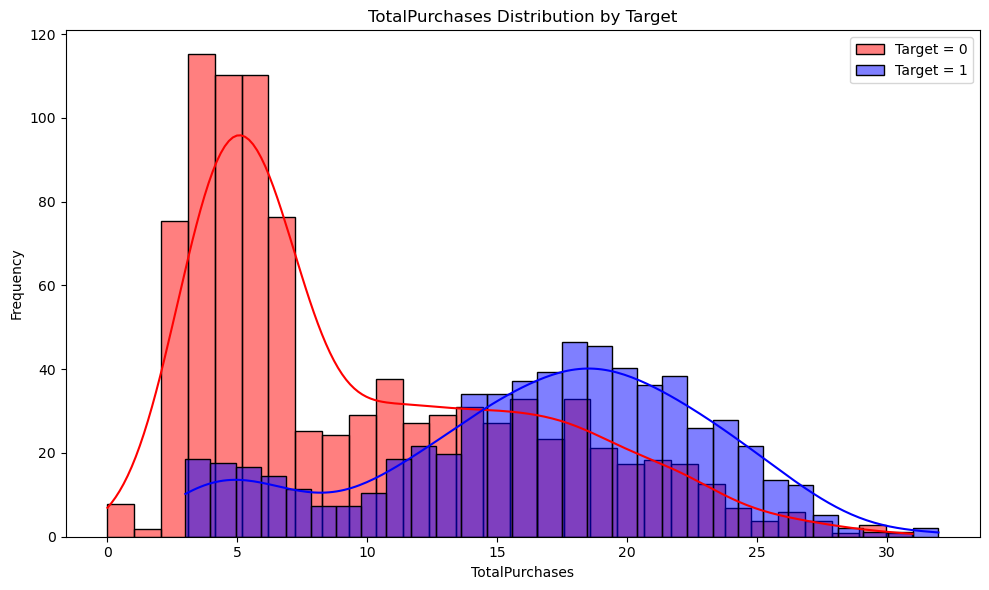

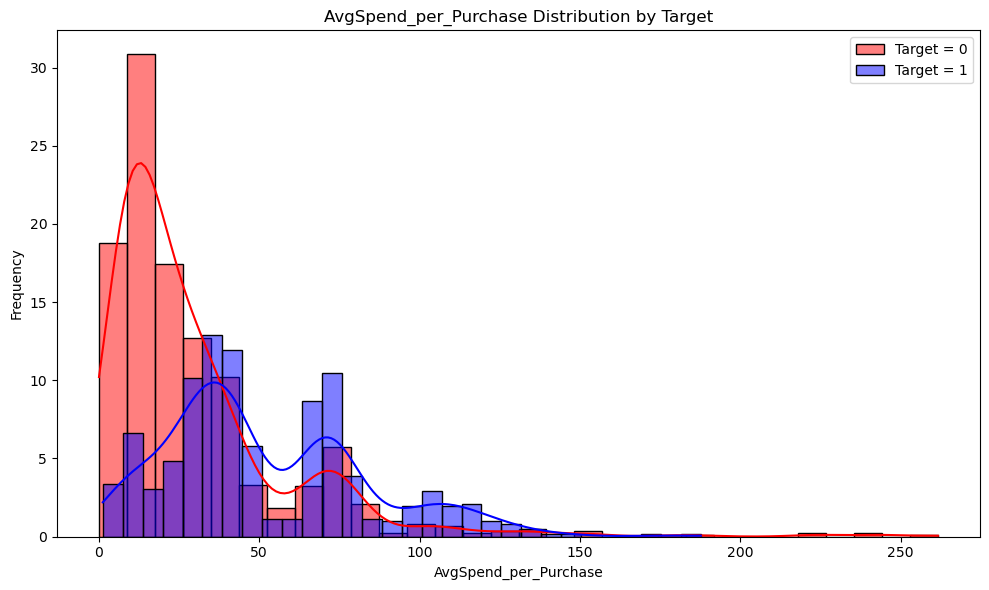

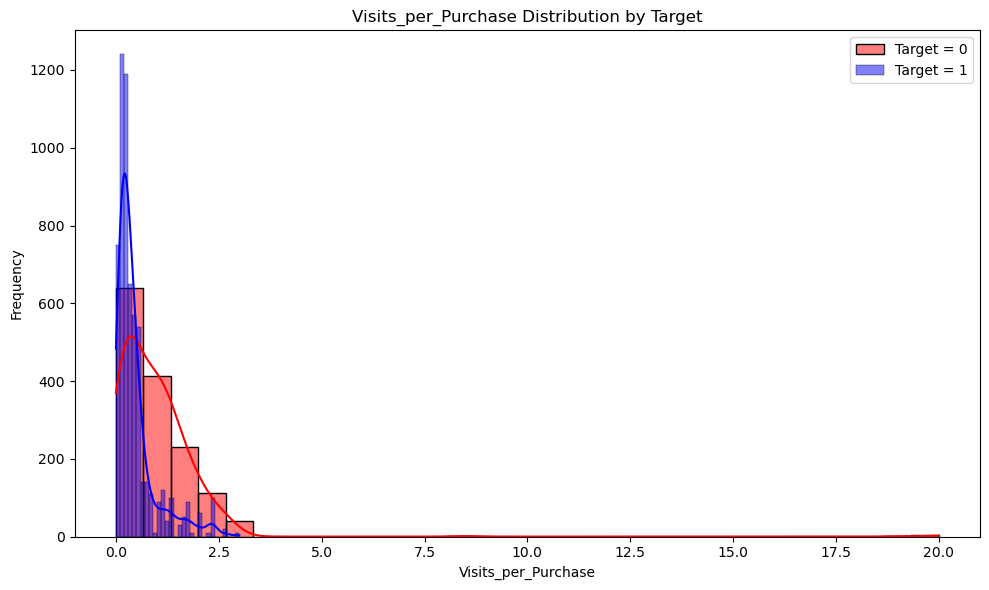

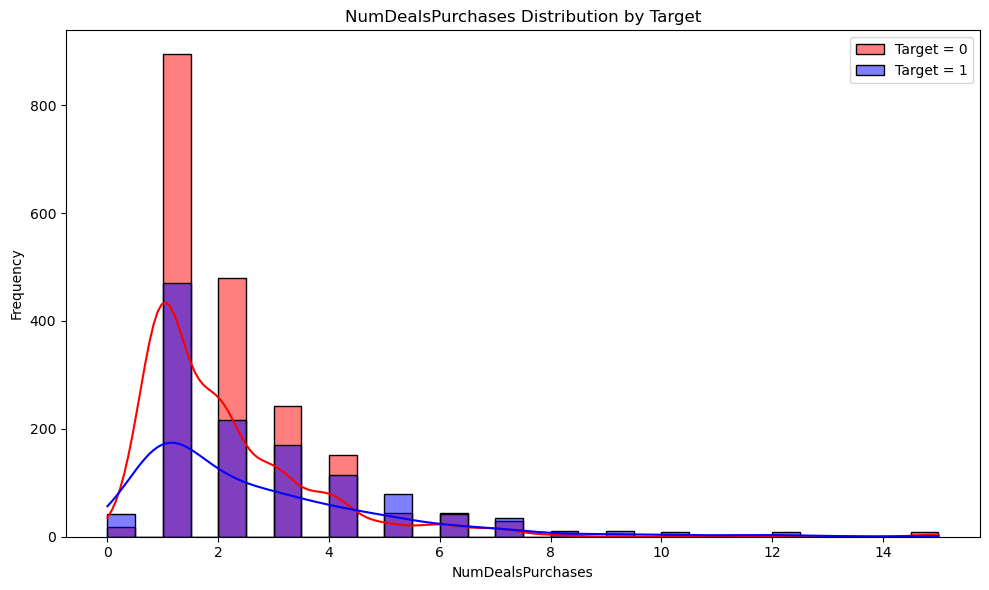

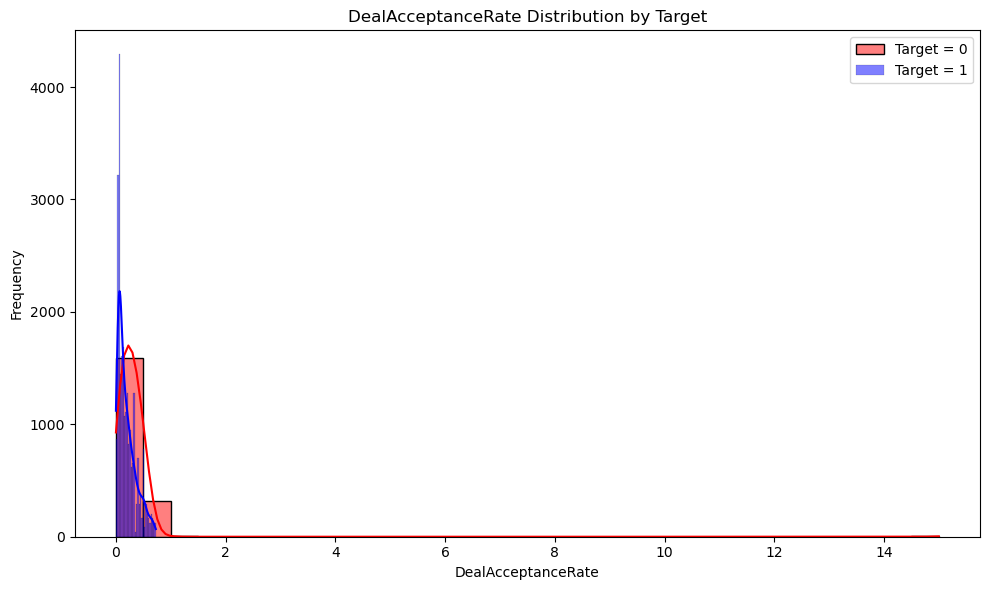

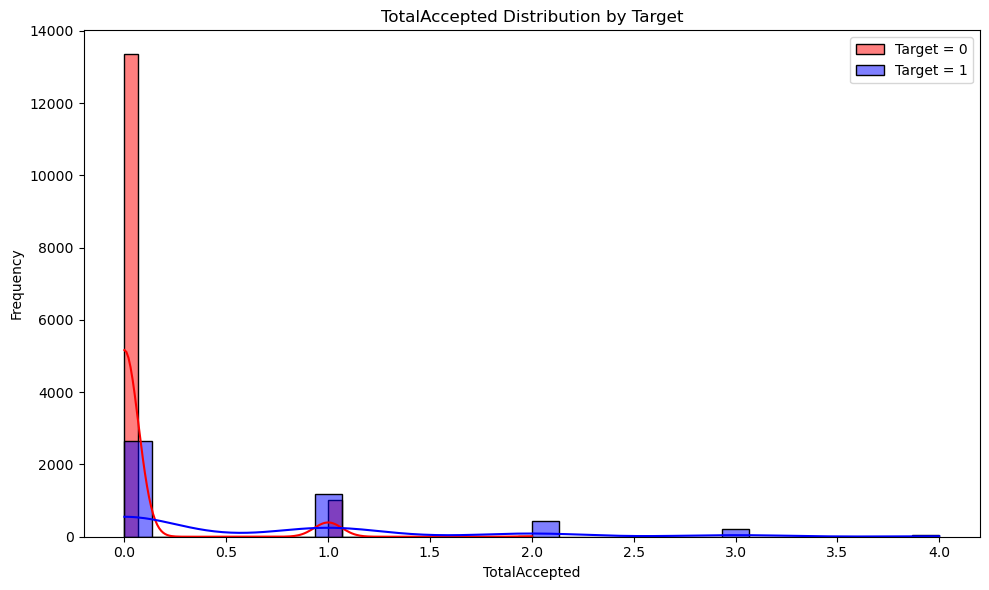

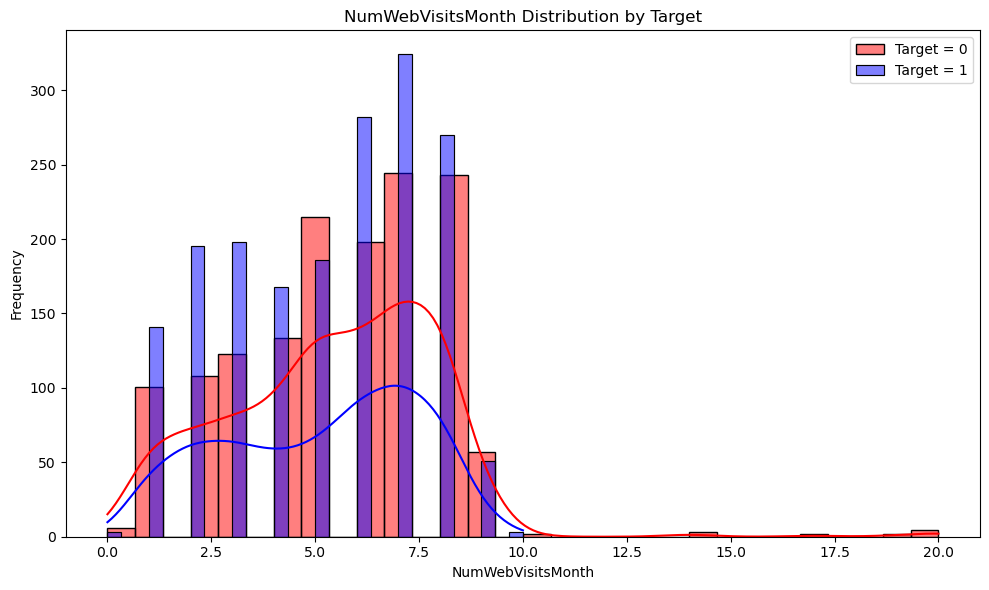

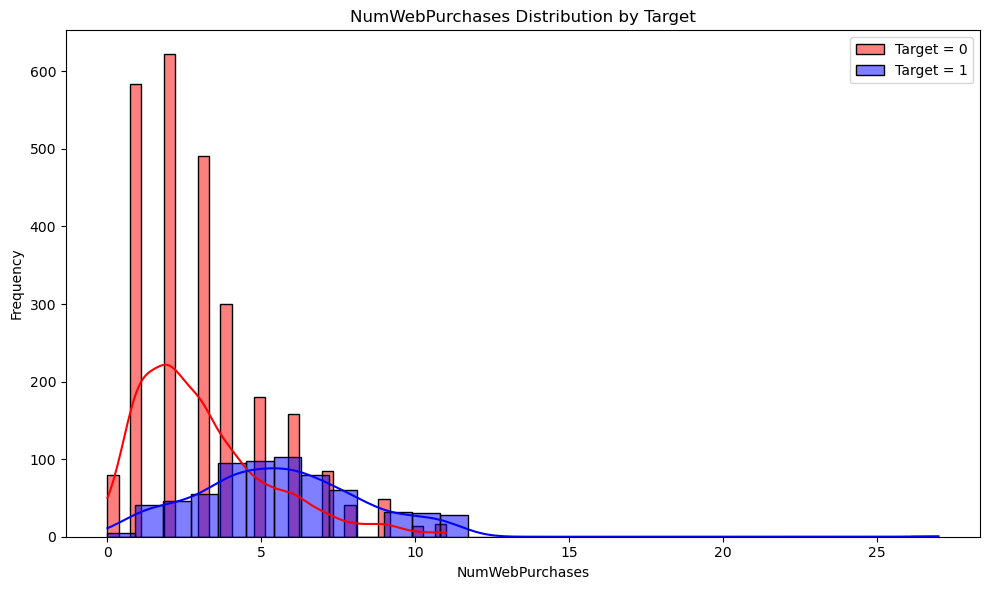

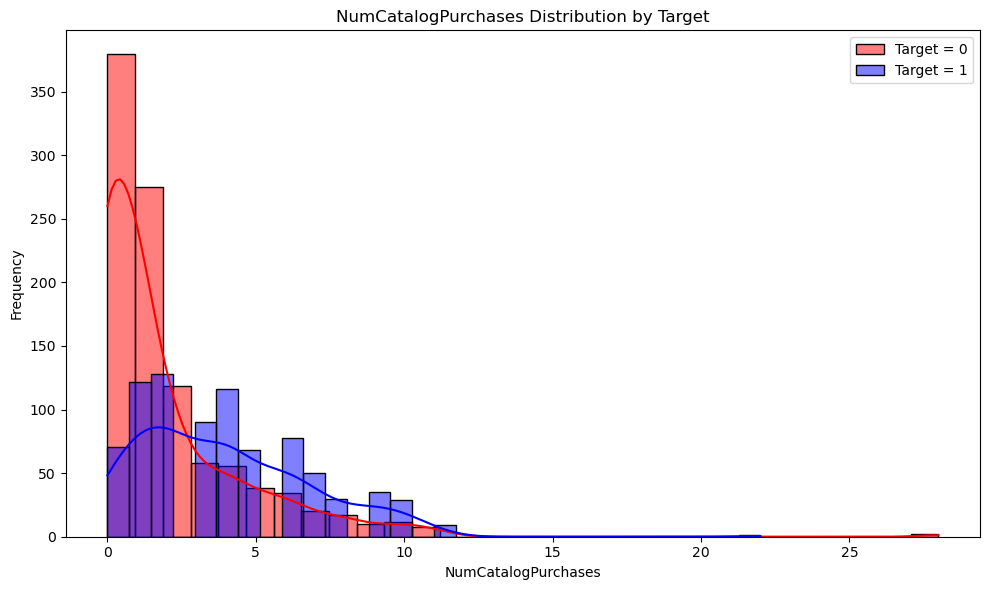

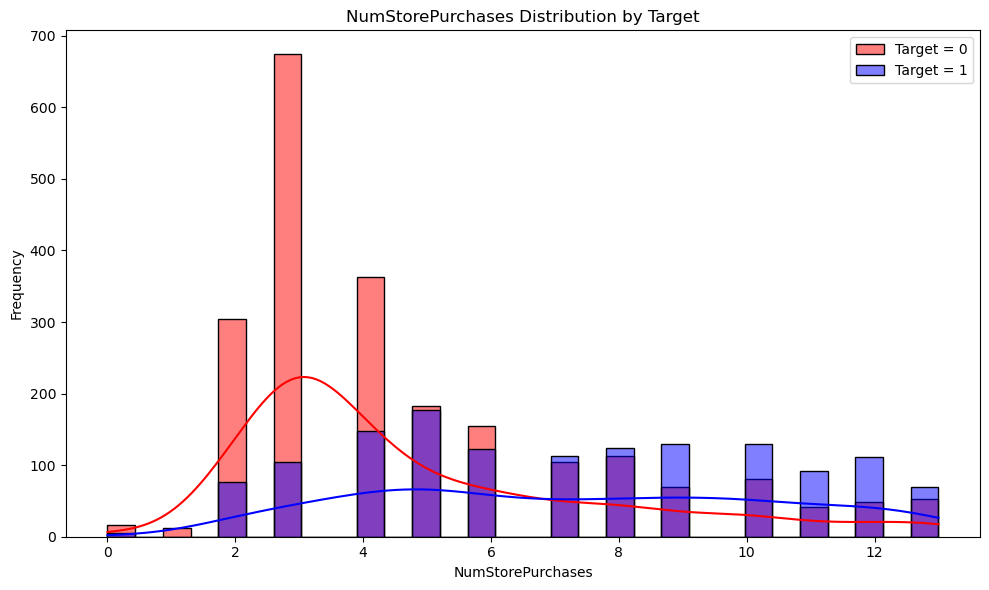

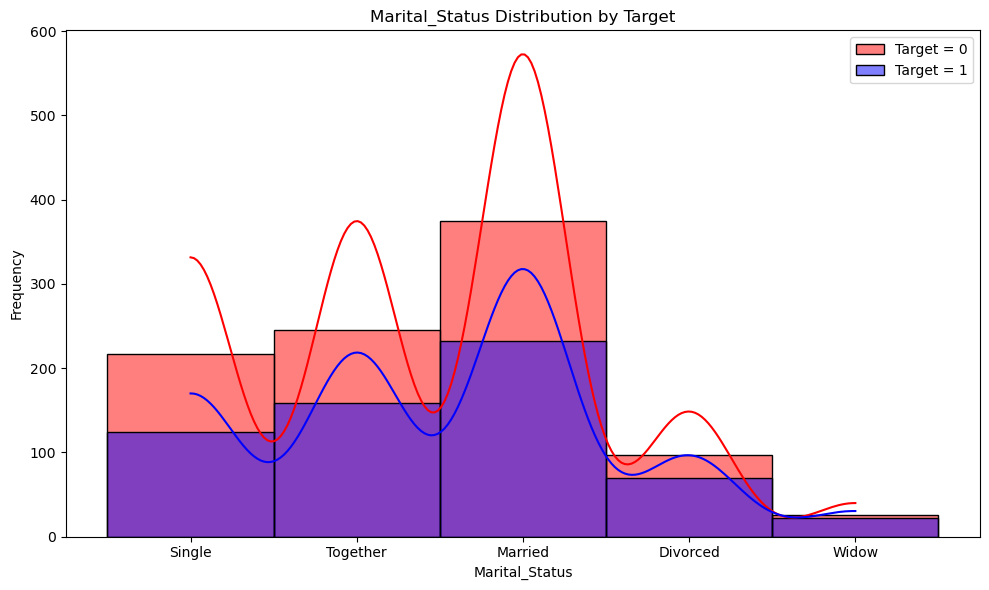

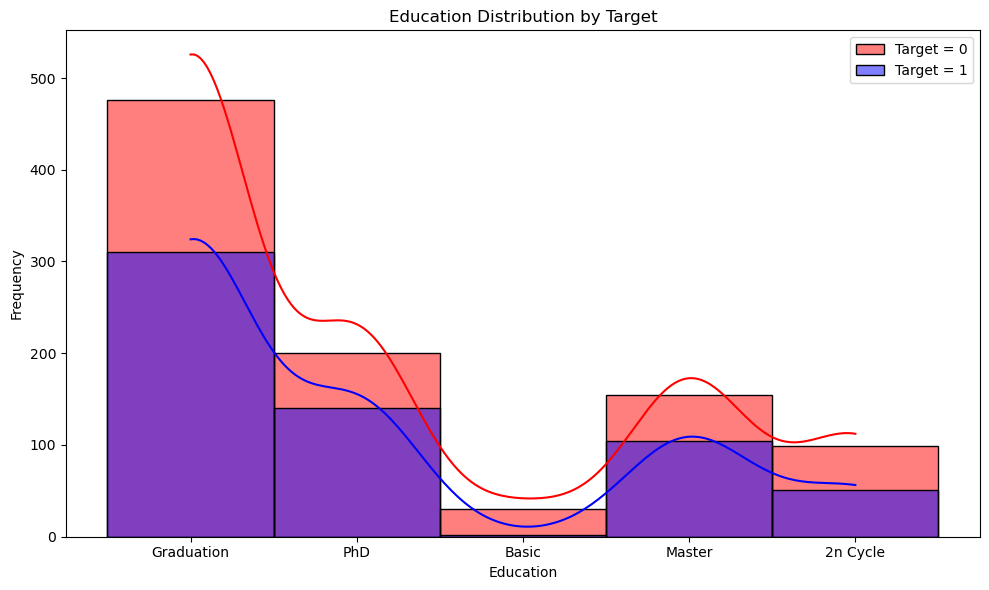

In [45]:
for i in feature_cols:
    plot_distribution_by_target(train_proc, column=i, target_column='Target')